# Company stock prediction

/var/folders/4f/wdty282j51ddljklq5t8rkc00000gn/T/ipykernel_58192/951633310.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/Users/kushalsathyanarayan/Desktop/projects/AIML/stock-market-prediction/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Columns in the downloaded data: MultiIndex([( 'Close', 'MSFT'),
            (  'High', 'MSFT'),
            (   'Low', 'MSFT'),
            (  'Open', 'MSFT'),
            ('Volume', 'MSFT')],
           names=['Price', 'Ticker'])

Shape of data after selecting 'Close' column: (2651, 1)
Data head after selection:
                 Close
Date                 
2015-01-02  39.998692
2015-01-05  39.630890
2015-01-06  39.049198
2015-01-07  39.545341
2015-01-08  40.708694

Building and training the LSTM model...
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 66s 32ms/step - loss: 0.0020
Model training complete.

Making predictions and plotting results...
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


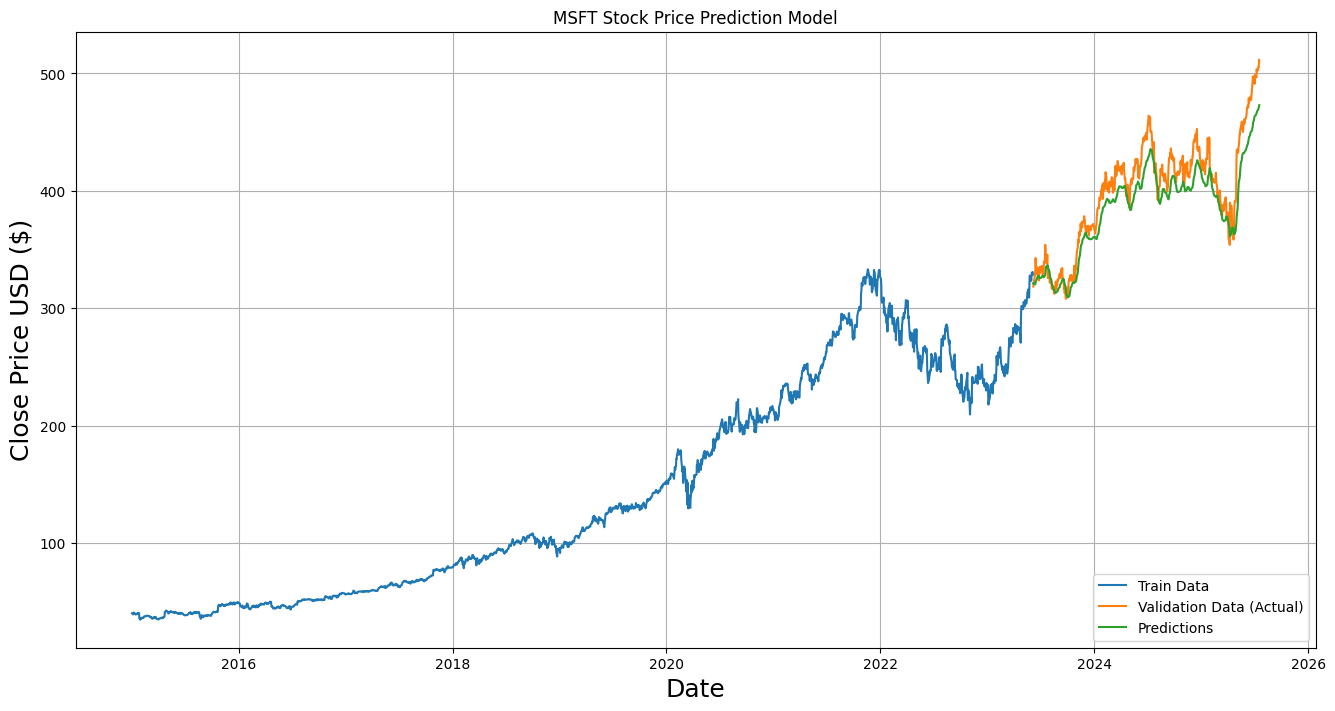


Prediction and plotting complete!


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

ticker_symbol = input("Enter the stock ticker symbol (e.g., AAPL, GOOGL, MSFT): ").upper()

start_date = '2015-01-01'
end_date = dt.datetime.now() 

print(f"\nDownloading historical data for {ticker_symbol} from {start_date} to {end_date.strftime('%Y-%m-%d')}...")

try:
    data = yf.download(ticker_symbol, start=start_date, end=end_date)

    if data.empty:
        print(f"Error: No data found for ticker symbol '{ticker_symbol}' or date range. Please check the ticker and try again.")
        exit()

    print("\nColumns in the downloaded data:", data.columns)

    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs('Close', level='Price', axis=1)
        data.columns = ['Close']
    else:
        if 'Close' in data.columns:
            data = data[['Close']]
        elif 'Adj Close' in data.columns:
            data = data[['Adj Close']]
            data = data.rename(columns={'Adj Close': 'Close'}) 
        else:
            print(f"Error: Neither 'Close' nor 'Adj Close' column found in data for {ticker_symbol}.")
            exit()


except Exception as e:
    print(f"An error occurred during data download or initial processing: {e}")
    exit()

print("\nShape of data after selecting 'Close' column:", data.shape)
print("Data head after selection:\n", data.head())

dataset = data.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

training_data_len = int(np.ceil(len(scaled_data) * .8))
train_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

prediction_days = 60
for i in range(prediction_days, len(train_data)):
    x_train.append(train_data[i-prediction_days:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print("\nBuilding and training the LSTM model...")
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=1, epochs=1)
print("Model training complete.")

print("\nMaking predictions and plotting results...")

test_data = scaled_data[training_data_len - prediction_days:, :]
x_test = []
y_test = dataset[training_data_len:, :] 

for i in range(prediction_days, len(test_data)):
    x_test.append(test_data[i-prediction_days:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) 

train = data.iloc[:training_data_len].copy()
valid = data.iloc[training_data_len:].copy()

valid.loc[:, 'Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title(f'{ticker_symbol} Stock Price Prediction Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close']) 
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train Data', 'Validation Data (Actual)', 'Predictions'], loc='lower right')
plt.grid(True)
plt.show()

print("\nPrediction and plotting complete!")